In [12]:
import time
import math
import pyvisa
from qcodes.instrument_drivers.Keysight import Keysight33522B
import qcodes as qc
from qcodes.dataset import do0d
from qcodes.instrument_drivers.Keysight import KeysightInfiniium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import pickle

In [13]:
rm = pyvisa.ResourceManager()
instrument = rm.open_resource('TCPIP0::K-33522B-02009.local::inst0::INSTR')

In [ ]:
instrument_id = instrument.query('*IDN?')
print(f"Connected to: {instrument_id.strip()}")

Connected to: Agilent Technologies,33522B,SG62002009,5.03-3.15-2.00-58-00


In [ ]:
ks = Keysight33522B('ks','TCPIP0::K-33522B-02009.local::inst0::INSTR')

Connected to: Agilent Technologies 33522B (serial:SG62002009, firmware:5.03-3.15-2.00-58-00) in 1.26s


In [ ]:
class waveform:
    """
    Base class for a waveform.

    Not to be instantiated directly.
    """
    def __init__(self, frequency=1e6, amplitude=1.0, offset=0.0, phase = 0.0, channel = 1):
        if frequency <= 0 or frequency > 30e6:
            raise ValueError("Frequency must be between 0 and 30 MHz.")

        self.frequency = frequency
        self.amplitude = amplitude
        self.offset = offset
        self.phase = phase
        self.channel = channel

    def apply(self, instrument):
        #Get channel
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2

        # Set the parameters for the waveform
        if self.shape != 'PRBS' and self.shape != 'NOIS' and self.shape != 'ARB' and self.shape != 'DC':
            channel.frequency(self.frequency)
        channel.amplitude(self.amplitude)
        channel.offset(self.offset)
        if self.shape != 'DC':
            channel.phase(self.phase)

        # Set the waveform type
        channel.function_type(self.shape)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        # Ensure the wave is applied correctly
        if channel.function_type() != self.shape:
            raise ValueError("Failed to set the waveform type to " + self.shape + ".")
        if self.shape != 'PRBS' and self.shape != 'NOIS' and self.shape != 'ARB' and self.shape != 'DC':
            if channel.frequency() != self.frequency:
                raise ValueError("Frequency setting did not apply correctly.")
        # if self.shape == 'PRBS':
        #     if channel.write('SOURce1:FUNCtion:PRBS:RATE?') != self.bit_rate:
        #         raise ValueError("Bit rate setting did not apply correctly.")
        if self.shape != 'DC':
            if channel.amplitude() != self.amplitude:
                raise ValueError("Amplitude setting did not apply correctly.")
        if channel.offset() != self.offset:
            raise ValueError("Offset setting did not apply correctly.")
        if self.shape != 'DC':
            if channel.phase() != self.phase:
                raise ValueError("Phase setting did not apply correctly.")
        print(f"{self.shape} wave applied on channel {self.channel}: ")
        if self.shape != 'PRBS' and self.shape != 'NOIS' and self.shape != 'ARB'and self.shape != 'DC':
            print(f"Frequency={self.frequency} Hz, ")
        if self.shape != 'DC':
            print(f"Amplitude={self.amplitude} Vpp, ")
        print(f"Offset={self.offset} V, ")
        if self.shape != 'NOIS' and self.shape != 'ARB' and self.shape != 'DC':
            print(f"Phase={self.phase} degrees")

    def set_frequency(self, instrument, frequency):
        if frequency <= 0 or frequency > 30e6:
            raise ValueError("Frequency must be between 0 and 30 MHz.")
        
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        channel.frequency(frequency)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.frequency = frequency
        if channel.frequency() != self.frequency:
                raise ValueError("Frequency setting did not apply correctly.")
        print(f"Frequency set to {self.frequency} Hz on channel {self.channel}.")
    def set_amplitude(self, instrument, amplitude):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        channel.amplitude(amplitude)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.amplitude = amplitude
        
        if channel.amplitude() != self.amplitude:
                raise ValueError("Amplitude setting did not apply correctly.")
        print(f"Amplitude set to {self.amplitude} Vpp on channel {self.channel}.")
    def set_offset(self, instrument, offset):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        channel.offset(offset)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.offset = offset
        if channel.offset() != self.offset:
                raise ValueError("Offset setting did not apply correctly.")
        print(f"Offset set to {self.offset} V on channel {self.channel}.")
    def set_phase(self, instrument, phase):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        channel.phase(phase)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.phase = phase
        if channel.phase() != self.phase:
                raise ValueError("Phase setting did not apply correctly.")
        print(f"Phase set to {self.phase} degrees on channel {self.channel}.")
    def sweep_frequency(self, instrument, start_freq, stop_freq, return_time, hold_time, sweep_time, sweep_spacing):
        #Parameter constraints
        if start_freq <= 1e-6 or start_freq > 30e6:
            raise ValueError("Frequency must be between 0 and 30 MHz.")
        if sweep_spacing == 'LIN':
            if sweep_time < 1e-3 or sweep_time > 250000:
                raise ValueError("Linear sweep time must be between 1ms and 250000 seconds.")
        elif sweep_spacing == 'LOG':
            if sweep_time < 1e-3 or sweep_time > 500:
                raise ValueError("Logarithmic sweep time must be between 1ms and 500 seconds.")
        if (hold_time < 0 or hold_time > 3600) or (return_time < 0 or return_time > 3600):
            raise ValueError("Hold and return times must be between 0 and 3600 seconds.")
        
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        #Set channel to sweep mode
        channel.frequency_mode("SWEEP")
        channel.write('SOURce' +str(self.channel)+':SWEep:SPACing ' + str(sweep_spacing))
        channel.write('SOURce' +str(self.channel)+':SWEep:TIMe ' + str(int(sweep_time)))
        channel.write('SOURce' +str(self.channel)+':SWEep:RTIMe ' + str(int(return_time)))
        channel.write('SOURce' +str(self.channel)+':SWEep:HTIMe ' + str(int(hold_time)))
        channel.write('SOURce' +str(self.channel)+':FREQuency:STARt ' + str(int(start_freq)))
        channel.write('SOURce' +str(self.channel)+':FREQuency:STOP ' + str(int(stop_freq)))
        channel.write('SOURce' +str(self.channel)+':SWEep:STATe ON')

        #Ensure waveform generator hasn't outputted an error
        # error_message = instrument.ask("SYSTem:ERRor?")
        # print(error_message)
        
        # while sweep_time > 0:
        #     time.sleep(1)
        #     sweep_time -= 1
        #     print(f"Sweeping on channel {self.channel} for {sweep_time} seconds...")
        
        # channel.write('SOURce' +str(self.channel)+':SWEep:STATe OFF')
        # print(f"Sweep completed on channel {self.channel}.")
    # def sweep_amplitude(self, instrument, start_amp, stop_amp, return_time, hold_time, sweep_time, sweep_spacing):
    #     #Does not currently work
    #     if self.channel == 1:
    #         channel = instrument.ch1
    #     else:
    #         channel = instrument.ch2
        
    #     #Set channel to sweep mode
    #     channel.write('SOURce' +str(self.channel)+':AMPLitude:MODE SWEep')
    #     channel.write('SOURce' +str(self.channel)+':SWEep:SPACing ' + str(sweep_spacing))
    #     channel.write('SOURce' +str(self.channel)+':SWEep:TIMe ' + str(int(sweep_time)))
    #     channel.write('SOURce' +str(self.channel)+':SWEep:RTIMe ' + str(int(return_time)))
    #     channel.write('SOURce' +str(self.channel)+':SWEep:HTIMe ' + str(int(hold_time)))
    #     channel.write('SOURce' +str(self.channel)+':AMPLitude:STARt ' + str(int(start_amp)))
    #     channel.write('SOURce' +str(self.channel)+':AMPLitude:STOP ' + str(int(stop_amp)))
    #     channel.write('SOURce' +str(self.channel)+':SWEep:STATe ON')

    #     #Ensure waveform generator hasn't outputted an error
    #     error_message = instrument.ask("SYSTem:ERRor?")
    #     print(error_message)

    #     while sweep_time > 0:
    #         time.sleep(1)
    #         sweep_time -= 1
    #         print(f"Sweeping on channel {self.channel} for {sweep_time} seconds...")
        
    #     channel.write('SOURce' +str(self.channel)+':SWEep:STATe OFF')
    #     print(f"Sweep completed on channel {self.channel}.")

    def output_on(self, instrument):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2

        if channel.output() == 'OFF':
            channel.output('ON')
            print(f"Output on channel {self.channel} turned ON.")
        else:
            print(f"Output on channel {self.channel} already turned ON.")
    def output_off(self, instrument):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        if channel.output() == 'ON':
            channel.output('OFF')
            print(f"Output on channel {self.channel} turned OFF.")
        else:
            print(f"Output on channel {self.channel} already turned OFF.")

        #channel.write('OUTPut' + str(self.channel) + ' ON')
    # def toggle_sweep(self, instrument):
    #     if self.channel == 1:
    #         channel = instrument.ch1
    #     else:
    #         channel = instrument.ch2
        
    #     if channel.write('SOURce' + str(self.channel) + ':SWEep:STATe?') == 'ON':
    #         channel.write('SOURce' + str(self.channel) + ':SWEep:STATe OFF')
    #         print(f"Sweep on channel {self.channel} turned OFF.")
    #     else:
    #         channel.write('SOURce' + str(self.channel) + ':SWEep:STATe ON')
    #         print(f"Sweep on channel {self.channel} turned ON.")



In [ ]:
class sine_wave(waveform):
    """
    Class for a sine wave (child class of waveform).

    This class sets the waveform type to sine and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'SIN' by default.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'SIN'

    def apply(self, instrument):
        super().apply(instrument)

In [ ]:
sine_wave1 = sine_wave(frequency=10e6, amplitude=2.0, offset=0.0, phase=0, channel=1)
sine_wave1.apply(ks)
time.sleep(1)  # Wait for the waveform to apply
sine_wave1.set_frequency(ks, 15e6)
sine_wave1.set_amplitude(ks, 7.0)
sine_wave1.set_offset(ks, 1.0)
sine_wave1.set_phase(ks, 45.0)

sine_wave1.output_on(ks)  # Output on channel 1

+0,"No error"
SIN wave applied on channel 1: 
Frequency=10000000.0 Hz, 
Amplitude=2.0 Vpp, 
Offset=0.0 V, 
Phase=0 degrees
+0,"No error"
Frequency set to 15000000.0 Hz on channel 1.
+0,"No error"
Amplitude set to 7.0 Vpp on channel 1.
+0,"No error"
Offset set to 1.0 V on channel 1.
+0,"No error"
Phase set to 45.0 degrees on channel 1.
Output on channel 1 turned ON.


In [ ]:
sine_wave1.sweep_frequency(ks, start_freq=5e6, stop_freq=7e6, return_time = 1, hold_time = 5, sweep_time=5, sweep_spacing='LIN')

+0,"No error"
Sweeping on channel 1 for 4 seconds...
Sweeping on channel 1 for 3 seconds...
Sweeping on channel 1 for 2 seconds...
Sweeping on channel 1 for 1 seconds...
Sweeping on channel 1 for 0 seconds...
Sweep completed on channel 1.


In [ ]:
class square_wave(waveform):
    """
    Class for a square wave (child class of waveform).

    This class sets the waveform type to square and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'SQU' by default.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'SQU'

    def apply(self, instrument):
        super().apply(instrument)

In [ ]:
square_wave1 = square_wave(frequency=25e6, amplitude=5.3, offset=0.0, phase=0, channel=1)
square_wave1.apply(ks)

time.sleep(1)  # Wait for the waveform to apply
square_wave1.set_frequency(ks, 6e3)
square_wave1.set_amplitude(ks, 7.0)
square_wave1.set_offset(ks, 1.0)
square_wave1.set_phase(ks, 45.0)

square_wave1.output_on(ks)  # Output on channel 1
time.sleep(3)
square_wave1.output_off(ks)  # Output off channel 1

+0,"No error"
SQU wave applied on channel 1: 
Frequency=25000000.0 Hz, 
Amplitude=5.3 Vpp, 
Offset=0.0 V, 
Phase=0 degrees
+0,"No error"
Frequency set to 6000.0 Hz on channel 1.
+0,"No error"
Amplitude set to 7.0 Vpp on channel 1.
+0,"No error"
Offset set to 1.0 V on channel 1.
+0,"No error"
Phase set to 45.0 degrees on channel 1.
Output on channel 1 already turned ON.
Output on channel 1 turned OFF.


In [ ]:
square_wave1.sweep_frequency(ks, start_freq=1e6, stop_freq=10e6, return_time = 0, hold_time = 5, sweep_time=5, sweep_spacing='LIN')

+0,"No error"
Sweeping on channel 1 for 4 seconds...
Sweeping on channel 1 for 3 seconds...
Sweeping on channel 1 for 2 seconds...
Sweeping on channel 1 for 1 seconds...
Sweeping on channel 1 for 0 seconds...
Sweep completed on channel 1.


In [ ]:
class triangle_wave(waveform):
    """
    Class for a triangle wave (child class of waveform).

    This class sets the waveform type to triangle and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'TRI' by default.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'TRI'

    def apply(self, instrument):
        super().apply(instrument)

In [ ]:
triangle_wave1 = triangle_wave(frequency=14e3, amplitude=9.0, offset=0.0, phase=90, channel=1)
triangle_wave1.apply(ks)

triangle_wave1.output_on(ks)  # Toggle output on channel 1
time.sleep(3)
triangle_wave1.output_off(ks)  # Toggle output off channel 1

-222,"Data out of range;value clipped to upper limit."


ValueError: Phase setting did not apply correctly.

In [ ]:
class ramp_wave(waveform):
    """
    Class for a ramp wave (child class of waveform).

    This class sets the waveform type to ramp and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'RAMP' by default.
    """
    def __init__(self, ramp_symmetry=50.00, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'RAMP'
        self.ramp_symmetry = ramp_symmetry

    def apply(self, instrument):
        super().apply(instrument)
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        channel.ramp_symmetry(self.ramp_symmetry)

    def set_ramp_symmetry(self, instrument, ramp_symmetry):
        if not (0 <= ramp_symmetry <= 100):
            raise ValueError("Ramp symmetry must be between 0 and 100.")
        
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        channel.ramp_symmetry(ramp_symmetry)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.ramp_symmetry = ramp_symmetry
        
        if channel.ramp_symmetry() != self.ramp_symmetry:
                raise ValueError("Ramp symmetry setting did not apply correctly.")
        print(f"Ramp symmetry set to {self.ramp_symmetry}% on channel {self.channel}.")

In [ ]:
ramp_wave1 = ramp_wave(ramp_symmetry=65.00, frequency=14e3, amplitude=9.0, offset=0.0, phase=90, channel=1)
ramp_wave1.apply(ks)
time.sleep(1)  # Wait for the waveform to apply
ramp_wave1.set_ramp_symmetry(ks, 75.00)

time.sleep(1)  # Wait for the waveform to apply
ramp_wave1.set_frequency(ks, 6e3)
ramp_wave1.set_amplitude(ks, 7.0)
ramp_wave1.set_offset(ks, 1.0)
ramp_wave1.set_phase(ks, 45.0)

ramp_wave1.output_on(ks)  # Toggle output on channel 1
time.sleep(3)
ramp_wave1.output_off(ks)  # Toggle output off channel 1

+0,"No error"
RAMP wave applied on channel 1: 
Frequency=14000.0 Hz, 
Amplitude=9.0 Vpp, 
Offset=0.0 V, 
Phase=90 degrees
+0,"No error"
Ramp symmetry set to 75.0% on channel 1.
+0,"No error"
Frequency set to 6000.0 Hz on channel 1.
+0,"No error"
Amplitude set to 7.0 Vpp on channel 1.
+0,"No error"
Offset set to 1.0 V on channel 1.
+0,"No error"
Phase set to 45.0 degrees on channel 1.
Output on channel 1 turned ON.
Output on channel 1 turned OFF.


In [ ]:
ramp_wave1.sweep_frequency(ks, start_freq=1e6, stop_freq=10e6, return_time = 0, hold_time = 5, sweep_time=5, sweep_spacing='LIN')

-221,"Settings conflict; frequency reduced for ramp function"
Sweeping on channel 1 for 4 seconds...
Sweeping on channel 1 for 3 seconds...
Sweeping on channel 1 for 2 seconds...
Sweeping on channel 1 for 1 seconds...
Sweeping on channel 1 for 0 seconds...
Sweep completed on channel 1.


In [ ]:
class pulse_wave(waveform):
    """
    Class for a pulse wave (child class of waveform).

    This class sets the waveform type to pulse and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'PULS' by default.

    """
    def __init__(self, pulse_width=1e-6, lead_edge = 8.4e-9, trail_edge = 8.4e-9, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'PULS'
        self.pulse_width = pulse_width
        self.lead_edge = lead_edge
        self.trail_edge = trail_edge

    def apply(self, instrument):
        super().apply(instrument)

        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2

        channel.pulse_width(self.pulse_width)
        channel.write('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:LEADing ' + str(self.lead_edge))
        channel.write('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:TRAILing ' + str(self.trail_edge))

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)


        # Ensure the pulse is applied correctly
        if channel.pulse_width() != self.pulse_width:
            raise ValueError("Pulse width setting did not apply correctly.")
        if not math.isclose(float(instrument.ask('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:LEADing?')[1:]), self.lead_edge):
                raise ValueError("Lead edge setting did not apply correctly.")
        if not math.isclose(float(instrument.ask('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:TRAILing?')[1:]), self.trail_edge):
                raise ValueError("Trail edge setting did not apply correctly.")
        
        print(f"Pulse width={self.pulse_width} s, "
              f"Lead edge={self.lead_edge} s, "
              f"Trail edge={self.trail_edge} s")

    def set_pulse_width(self, instrument, pulse_width):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        channel.pulse_width(pulse_width)

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.pulse_width = pulse_width
        
        if channel.pulse_width() != self.pulse_width:
                raise ValueError("Pulse width setting did not apply correctly.")
        print(f"Pulse width set to {self.pulse_width} seconds on channel {self.channel}.")

    def set_lead_edge(self, instrument, lead_edge):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        channel.write('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:LEADing ' + str(lead_edge))

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.lead_edge = lead_edge

        output_val = float(instrument.ask('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:LEADing?')[1:])

        if not math.isclose(output_val, self.lead_edge):
                raise ValueError("Lead edge setting did not apply correctly.")
        print(f"Lead edge set to {self.lead_edge} seconds on channel {self.channel}.")

    def set_trail_edge(self, instrument, trail_edge):
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        
        channel.write('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:TRAILing ' + str(trail_edge))

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        self.trail_edge = trail_edge

        output_val = float(instrument.ask('SOURce' +str(self.channel)+':FUNCtion:PULSe:TRANsition:TRAILing?')[1:])

        if not math.isclose(output_val, self.trail_edge):
                raise ValueError("Trail edge setting did not apply correctly.")
        print(f"Trail edge set to {self.trail_edge} seconds on channel {self.channel}.")

In [ ]:
pulse_wave1 = pulse_wave(pulse_width=34e-6, lead_edge = 10e-9, trail_edge = 9e-9, frequency=14e3, amplitude=9.0, offset=0.0, phase=90, channel=1)
pulse_wave1.apply(ks)
time.sleep(2)  # Wait for the waveform to apply
pulse_wave1.set_pulse_width(ks, 50e-6)
pulse_wave1.set_lead_edge(ks, 15e-9)
pulse_wave1.set_trail_edge(ks, 12e-9)

time.sleep(1)  # Wait for the waveform to apply
pulse_wave1.set_frequency(ks, 6e3)
pulse_wave1.set_amplitude(ks, 7.0)
pulse_wave1.set_offset(ks, 1.0)
pulse_wave1.set_phase(ks, 45.0)

pulse_wave1.output_on(ks)  # Toggle output on channel 1

-221,"Settings conflict; offset changed due to amplitude"
PULS wave applied on channel 1: 
Frequency=14000.0 Hz, 
Amplitude=9.0 Vpp, 
Offset=0.0 V, 
Phase=90 degrees
-221,"Settings conflict; both edge times decreased due to pulse width"
Pulse width=3.4e-05 s, Lead edge=1e-08 s, Trail edge=9e-09 s
-221,"Settings conflict; pulse width decreased due to period"
Pulse width set to 5e-05 seconds on channel 1.
+0,"No error"
Lead edge set to 1.5e-08 seconds on channel 1.
+0,"No error"
Trail edge set to 1.2e-08 seconds on channel 1.
+0,"No error"
Frequency set to 6000.0 Hz on channel 1.
+0,"No error"
Amplitude set to 7.0 Vpp on channel 1.
+0,"No error"
Offset set to 1.0 V on channel 1.
+0,"No error"
Phase set to 45.0 degrees on channel 1.
Output on channel 1 already turned ON.


In [ ]:
pulse_wave1.sweep_frequency(ks, start_freq=1e6, stop_freq=10e6, return_time = 0, hold_time = 5, sweep_time=5, sweep_spacing='LIN')

-221,"Settings conflict; both edge times decreased due to pulse width"
Sweeping on channel 1 for 4 seconds...
Sweeping on channel 1 for 3 seconds...
Sweeping on channel 1 for 2 seconds...
Sweeping on channel 1 for 1 seconds...
Sweeping on channel 1 for 0 seconds...
Sweep completed on channel 1.


In [ ]:
class PRBS_wave(waveform):
    """
    Class for a PRBS wave (child class of waveform).

    This class sets the waveform type to PRBS and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'PRBS' by default.
    """
    def __init__(self, bit_rate=1e9, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'PRBS'
        self.bit_rate = bit_rate

    def apply(self, instrument):
        super().apply(instrument)
        if self.channel == 1:
            channel = instrument.ch1
        else:
            channel = instrument.ch2
        # May not work properly
        if self.shape == "PRBS":
            channel.write('SOURce1:FUNCtion:PRBS:RATE ' + str(self.bit_rate))

In [ ]:
PRBS_wave1 = PRBS_wave(amplitude=3.0, offset=0.0, phase=90, channel=1)
PRBS_wave1.apply(ks)

-113,"Undefined header"
PRBS wave applied on channel 1: 
Amplitude=3.0 Vpp, 
Offset=0.0 V, 
Phase=90 degrees


In [ ]:
class noise_wave(waveform):
    """
    Class for a noise wave (child class of waveform).

    This class sets the waveform type to noise and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'NOIS' by default.
    """
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        self.shape = 'NOIS'

    #Setting bandwidth not yet implemented
    def apply(self, instrument):
        super().apply(instrument)    

In [ ]:
noise_wave1 = noise_wave(amplitude=3.0, offset=3.0, channel=1)
noise_wave1.apply(ks)

-113,"Undefined header"
NOIS wave applied on channel 1: 
Amplitude=3.0 Vpp, 
Offset=3.0 V, 


In [ ]:
class dc_wave(waveform):
    """
    Class for a DC wave (child class of waveform).

    This class sets the waveform type to DC and applies the parameters
    to the specified channel of the instrument.

    function_type is set to 'DC' by default.
    """
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        self.shape = 'DC'

    def apply(self, instrument):
        super().apply(instrument)    

In [ ]:
dc_wave1 = dc_wave(offset=2.0, channel=1)
dc_wave1.apply(ks)

-113,"Undefined header"
DC wave applied on channel 1: 
Offset=2.0 V, 


In [ ]:
mso = KeysightInfiniium('mso', 'TCPIP0::168.192.10.39::inst0::INSTR')

Connected to: Agilent Technologies DSO9104A (serial:SG50140101, firmware:03.01.0005) in 0.02s


[mso(KeysightInfiniium)] Unable to query bandwidth limits (('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking ':ACQ:BAND:TESTLIMITS?' to <KeysightInfiniium: mso>")). Setting limits to default.


In [ ]:
mso.ask('*IDN?')

'Agilent Technologies,DSO9104A,SG50140101,03.01.0005'

In [ ]:
mso.ch1.display(True)
mso.ch3.display(True)
mso.write(':STOP')
time.sleep(3)
mso.write(':RUN')

In [ ]:
mso.screenshot('./imagetest.png')

Screen image written to ./imagetest.png


array([[[235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        ...,
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255]],

       [[235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        ...,
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255]],

       [[235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        ...,
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255]],

       ...,

       [[235, 233, 230, 255],
        [167, 157, 143, 255],
        [167, 157, 143, 255],
        ...,
        [235, 233, 230, 255],
        [245, 244, 243, 255],
        [235, 233, 230, 255]],

       [[235, 233, 230, 255],
        [245, 244, 243, 255],
        [245, 244, 243, 255],
        ...,
        [245, 244, 243, 255],
        [245, 244, 243, 255],
        [235, 233, 230, 255]],

       [[235

In [ ]:
def autoscale(instrument):
    """
    Autoscale the specified channel of the instrument.
    """
    instrument.write(':AUToscale')

In [ ]:
sine_wave1.apply(ks)
sine_wave1.output_on(ks)  # Toggle output on MSO channel 1
time.sleep(2)
mso.write(':RUN')
time.sleep(2)
autoscale(mso)

NameError: name 'sine_wave1' is not defined

In [ ]:
def plot_waveform(instrument, channel):
    """
    Plot the waveform data from the specified channel of the instrument.
    """
    instrument.trigger_edge_source('CHAN' + str(channel))
    instrument.trigger_edge_slope("NEG")
    instrument.ch4.trigger_level(0)
    instrument.timebase_range(5e-3)

    #nPoints = 5000
    nPoints = 1000000
    instrument.acquire_points(nPoints)
    instrument.sample_rate(nPoints / mso.timebase_range())
    instrument.acquire_interpolate(0)

    do0d(getattr(instrument, f'ch{channel}').trace, do_plot=True)

Starting experimental run with id: 19. Using 'qcodes.dataset.do0d'


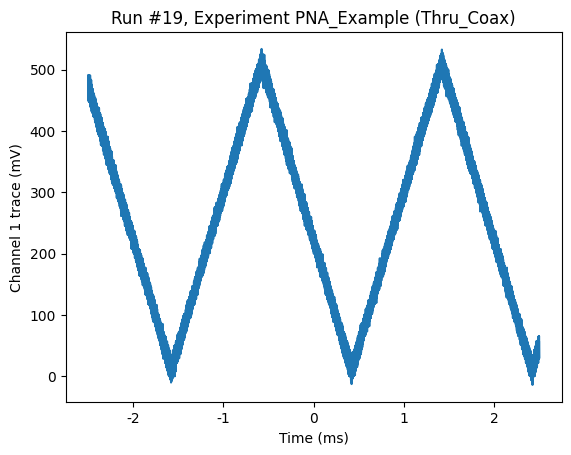

In [ ]:
#sine_wave1.set_amplitude(ks, 10.0)
plot_waveform(mso, 1)

In [ ]:
def get_measurements(instrument, channel):
    """
    Get frequency and amplitude measurements from the specified channel of the instrument.
    """
    ds, _, _ = do0d(getattr(instrument, f'ch{channel}').measure.amplitude, getattr(instrument, f'ch{channel}').measure.frequency)
    df = ds.to_pandas_dataframe()
    return df

In [ ]:
get_measurements(mso, 1)

Starting experimental run with id: 9. Using 'qcodes.dataset.do0d'


,mso_chan1_measure_amplitude,mso_chan1_measure_frequency
0,9.999990e+37,14995680.0


In [ ]:
def plot_waveforms(instrument, channels):
    """
    Plot waveforms from multiple channels of the instrument.
    """
    #autoscale(instrument)
    # Disable automatic digitization
    instrument.auto_digitize(False)

    getattr(instrument, f'ch{channels[0]}').display('on')
    getattr(instrument, f'ch{channels[1]}').display('on')

    # Set up trigger, sample rate, etc.
    nPoints = 5000
    instrument.acquire_points(nPoints)
    instrument.sample_rate(nPoints / mso.timebase_range())
    instrument.acquire_interpolate(0)
    
    instrument.trigger_edge_source('CHAN1')
    instrument.ch1.trigger_level(0)

    # Take the measurement (single digitize for both channels)
    instrument.digitize()

    # Acquire and plot both traces
    do0d(getattr(instrument, f'ch{channels[0]}').trace, getattr(instrument, f'ch{channels[1]}').trace, do_plot=True)

    instrument.write(':RUN')

In [ ]:
sin1 = sine_wave(frequency=10e6, amplitude=2.0, offset=0.0, phase=0, channel=1)
sin1.apply(ks)

sin1.output_on(ks)  # Toggle output on function generator channel 1

-221,"Settings conflict; offset changed due to amplitude"
SIN wave applied on channel 1: 
Frequency=10000000.0 Hz, 
Amplitude=2.0 Vpp, 
Offset=0.0 V, 
Phase=0 degrees
Output on channel 1 already turned ON.


In [ ]:
plot_waveforms(mso, [1, 3])

Received SIGINT, Will interrupt at first suitable time. Send second SIGINT to interrupt immediately.


KeyboardInterrupt: 

In [ ]:
def plot_waveforms_overlay(instrument, channels):
    """
    Plot waveforms from multiple channels of the instrument.
    """
    
    autoscale(instrument)

    # Disable automatic digitization
    instrument.auto_digitize(False)

    #Display both channels
    getattr(instrument, f'ch{channels[0]}').display('on')
    getattr(instrument, f'ch{channels[1]}').display('on')

    # Set up trigger, sample rate, etc.
    nPoints = 5000
    instrument.acquire_points(nPoints)
    instrument.sample_rate(nPoints / mso.timebase_range())
    instrument.acquire_interpolate(0)
    
    instrument.trigger_edge_source('CHAN1')
    instrument.ch1.trigger_level(0)

    #Take measurement (single digitize for both channels)
    instrument.digitize()

    # Get trace data from both channels
    y1 = getattr(instrument, f'ch{channels[0]}').trace()
    y2 = getattr(instrument, f'ch{channels[1]}').trace()

    # Calculate time axis manually
    t_range = instrument.timebase_range()  # total time window in s
    t_center = instrument.timebase_position()  # center of time window
    t_start = t_center - t_range / 2
    t_stop = t_center + t_range / 2
    x = np.linspace(t_start, t_stop, nPoints)

    # Plot both waveforms on the same axes (overlay)
    plt.figure()
    plt.plot(x, y1, label=f'Channel {channels[0]}')
    plt.plot(x, y2, label=f'Channel {channels[1]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Channel trace Voltage (V)')
    plt.legend()
    plt.title('Waveforms from Channels {} and {}'.format(channels[0], channels[1]))
    plt.show()

    instrument.write(':RUN')

    return (x, y1, y2)

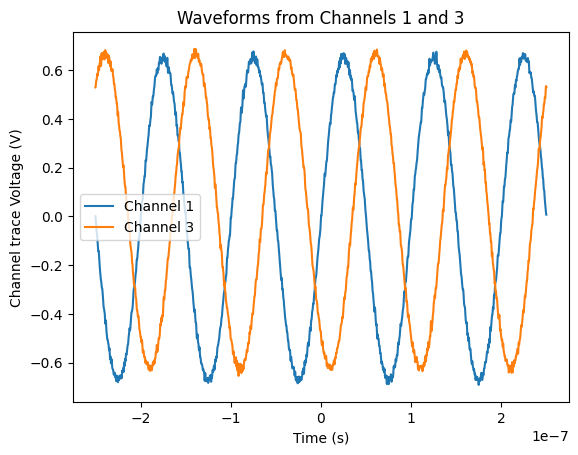

In [ ]:
(x, y1, y2) = plot_waveforms_overlay(mso, [1, 3])

In [ ]:
def calculate_time_delay(x, y1, y2):
    """
    Calculate the time delay between two waveforms using cross-correlation.
    """
    # Ensure y1 and y2 are numpy arrays
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    # Normalize the signals
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    # Cross-correlation
    correlation = np.correlate(y1, y2, mode='full')

    # Calculate lag (# of data pts/samples)
    # If lag is positive, y2 lags behind y1 by that many samples; if negative, y1 lags behind y2.

    #Center lag axis around 0 (lag of 0 (no shift) is at index len(y1) - 1))
    lag = np.argmax(correlation) - (len(y1) - 1)

    dt = x[1] - x[0]  # sample interval
    print("sample interval: ", dt)

    # Convert lag in samples to time delay by multiplying # of samples by sample interval:
    time_delay = lag * dt

    return time_delay

In [ ]:
calculate_time_delay(x, y1, y2)

sample interval:  1.0002000400077549e-10


np.float64(-3.500700140027142e-08)

In [ ]:
import numpy as np
A = np.array([1, 2, 3, 4, 5])
B = np.array([5, 4, 3, 2, 1])
print(np.correlate(A, B, mode='full'))

[ 1  4 10 20 35 44 46 40 25]


In [ ]:
def calculate_phase_velocity(time_delay, cable1, cable2):
    """
    Calculate the phase velocity given the time delay, connection cable lengths (in m).
    """
    if time_delay == 0:
        raise ValueError("Time delay cannot be zero for phase velocity calculation.")
    
    L = abs(cable1 - cable2)  # Length difference in meters
    
    phase_velocity = L / time_delay  # Phase velocity in m/s

    print(phase_velocity)
    
    return phase_velocity

In [ ]:
print(f"Phase velocity: {calculate_phase_velocity(calculate_time_delay(x, y1, y2), 7.4, 0.6096)} m/s")

NameError: name 'x' is not defined

In [ ]:
def measure_delta_t(instrument, channel1, channel2):
    return instrument.ask(f':MEASure:DELTatime? CHAN{channel1},CHAN{channel2}')
def measure_frequency(instrument, channel):
    return instrument.ask(f':MEASure:FREQuency? CHAN{channel}')

In [ ]:
def extract_sweep_delay_data(instrument, fg, wave, channel, channel2, sweep_time):
    """
    Extract time delay data from the specified channel of the instrument during a frequency sweep.
    """
    freqs = []
    delays = []

    start_time = time.time()

    #Being measuring time delay (delta t)
    getattr(instrument, f'ch{channel}').write(':MEASure:DELTatime CHAN1,CHAN3')

    getattr(instrument, f'ch{channel}').display(True)
    getattr(instrument, f'ch{channel2}').display(True)
    autoscale(instrument)

    wave.sweep_frequency(fg, start_freq=1e6, stop_freq=10e6, return_time = 0, hold_time = 5, sweep_time=5, sweep_spacing='LIN')

    while True:
        now = time.time()
        elapsed = now - start_time
        if elapsed > sweep_time:
            break

        # Measure frequency and time delay
        delay = measure_delta_t(instrument, channel, channel2)
        freq = measure_frequency(instrument, channel)

        #data.append({'frequency': float(freq), 'delay': float(delay)})
        freqs.append(float(freq))
        delays.append(float(delay))
        time.sleep(0.1)
    getattr(fg, f'ch{channel}').write('SOURce' +str(channel)+':SWEep:STATe OFF')
    #df = pd.DataFrame(data)

    return freqs, delays

In [ ]:
#Measuring phase velocity from sweep of sine wave frequency
x, y = extract_sweep_delay_data(mso, ks, sin1, 1, 3, 5)


In [ ]:
# freq_VOP = []
# for freq, delay in zip(freq_delay['frequency'], freq_delay['delay']):
#     freq_VOP.append({'frequency':freq, 'VOP': calculate_phase_velocity(delay, 7.4, 0.6096)})
# pd.DataFrame(freq_VOP).plot(title='Phase Velocity (m/s) vs Frequency (Hz)', kind='scatter', x='frequency', y='VOP', grid=True)

def plot_freq_vop(x, y):
    """
    Plot the phase velocity vs. frequency data given frequency and time delay data obtained from a sweep.
    """

    #Clean data
    x_noisy = np.array(x)
    y_noisy = np.array(y)

    VOP = []
    for delay in y_noisy:
        VOP.append(abs(calculate_phase_velocity(delay, 7.4, 0.6096)))

    VOP = np.array(VOP)

    y_threshold = 1e9  # Threshold for filtering phase velocity outliers
    x_threshold = 30e6  # Threshold for filtering frequency outliers

    mask = (np.abs(VOP) < y_threshold) & (np.abs(x_noisy) < x_threshold)

    x_clean = x_noisy[mask]
    y_clean = VOP[mask]

    plt.figure()
    plt.scatter(x_clean,y_clean)
    plt.xlabel("frequency, Hz")
    plt.ylabel("phase velocity, m/s")
    plt.title("phase velocity vs. frequency")
    plt.grid(True)
    plt.ylim(0, 3e8)  # Set y-axis limit
    plt.show()

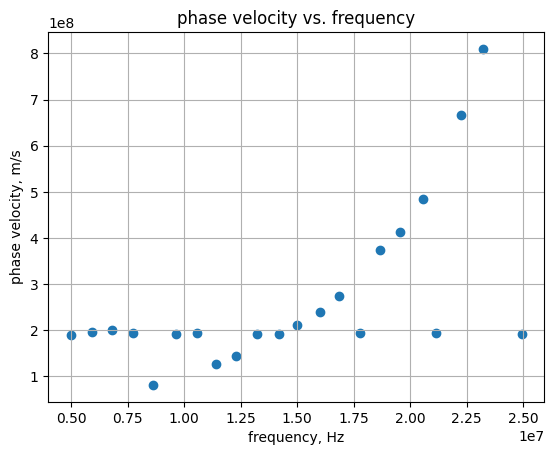

In [ ]:
plot_freq_vop(x, y)

In [ ]:
pulse_wave2 = pulse_wave(pulse_width=84e-9, lead_edge = 8.4e-9, trail_edge = 8.4e-9, frequency=5e6, amplitude=3, channel=1)
pulse_wave2.apply(ks)

pulse_wave2.output_on(ks)  # Toggle output on function generator channel 1

+0,"No error"
PULS wave applied on channel 1: 
Frequency=5000000.0 Hz, 
Amplitude=3 Vpp, 
Offset=0.0 V, 
Phase=0.0 degrees
+0,"No error"
Pulse width=8.4e-08 s, Lead edge=8.4e-09 s, Trail edge=8.4e-09 s
Output on channel 1 already turned ON.


In [ ]:
mso.write(':RUN')


#Measuring phase velocity from sweep of pulse wave frequency
x2, y2 = extract_sweep_delay_data(mso, ks, pulse_wave2, 1, 3, 10)
plot_freq_vop(x2, y2)

NameError: name 'extract_sweep_delay_data' is not defined

In [ ]:
ks.ch1.write('SOURce' + str(1) + ':SWEep:STATe OFF')

In [ ]:
import pandas as pd

def extract_sweep_delay_data2(instrument, fg, wave, channel, channel2, sweep_time):
    """
    Extract time delay data from the specified channel of the instrument during a frequency sweep.
    """

    wave.apply(ks)

    wave.output_on(ks)  # Toggle output on function generator channel 1

    freqs = []
    delays = []
    delays2 = []
    
    start_time = time.time()

    #Being measuring time delay (delta t)
    getattr(instrument, f'ch{channel}').write(':MEASure:DELTatime CHAN1,CHAN3')

    getattr(instrument, f'ch{channel}').display(True)
    getattr(instrument, f'ch{channel2}').display(True)
    autoscale(instrument)

    wave.sweep_frequency(fg, start_freq=1e6, stop_freq=10e6, return_time = 5, hold_time = 5, sweep_time=5, sweep_spacing='LIN')

    time.sleep(3)  # Allow time for the sweep to start

    while True:
        now = time.time()
        elapsed = now - start_time
        if elapsed > sweep_time:
            break

        # Measure frequency and time delay
        delay = measure_delta_t(instrument, channel, channel2)
        freq = measure_frequency(instrument, channel)

        # Disable automatic digitization
        instrument.auto_digitize(False)

        #Measure time delay using correlation
        # Set up trigger, sample rate, etc.
        nPoints = 5000
        instrument.acquire_points(nPoints)
        instrument.sample_rate(nPoints / mso.timebase_range())
        instrument.acquire_interpolate(0)
        
        instrument.trigger_edge_source('CHAN1')
        instrument.ch1.trigger_level(0)

        #Take measurement (single digitize for both channels)
        instrument.digitize()

        # Get trace data from both channels
        y1 = getattr(instrument, f'ch{channel}').trace()
        y2 = getattr(instrument, f'ch{channel2}').trace()

        # Calculate time axis manually
        t_range = instrument.timebase_range()  # total time window in s
        t_center = instrument.timebase_position()  # center of time window
        t_start = t_center - t_range / 2
        t_stop = t_center + t_range / 2
        x = np.linspace(t_start, t_stop, nPoints)
        delay2 = calculate_time_delay(x, y1, y2)

        #data.append({'frequency': float(freq), 'delay': float(delay)})
        freqs.append(float(freq))
        delays.append(float(delay))
        delays2.append(float(delay2))
        time.sleep(0.1)
    getattr(fg, f'ch{channel}').write('SOURce' +str(channel)+':SWEep:STATe OFF')
    #df = pd.DataFrame(data)

    return freqs, delays, delays2

In [ ]:
def plot_freq_vop2(x, y, y2):
    """
    Plot the phase velocity vs. frequency data given frequency and time delay data obtained from a sweep (via delta measurement + correlation).
    """

    #Clean data
    x_noisy = np.array(x)
    y_noisy = np.array(y)
    y_noisy2 = np.array(y2)

    VOP1 = []
    VOP2 = []
    for delay in y_noisy:
        VOP1.append(abs(calculate_phase_velocity(delay, 7.4, 0.6096)))
    for delay in y_noisy2:
        VOP2.append(abs(calculate_phase_velocity(delay, 7.4, 0.6096)))

    VOP1 = np.array(VOP1)
    VOP2 = np.array(VOP2)   

    y_threshold = 1e9  # Threshold for filtering phase velocity outliers
    x_threshold = 30e6  # Threshold for filtering frequency outliers

    mask = (np.abs(VOP1) < y_threshold) & (np.abs(VOP2) < y_threshold) & (np.abs(x_noisy) < x_threshold)

    x_clean = x_noisy[mask]
    y_clean = VOP1[mask]
    y_clean2 = VOP2[mask]

    plt.figure()
    plt.scatter(x_clean, y_clean, label='Half Amplitude')
    plt.scatter(x_clean, y_clean2, color='red', label='Cross-Correlation')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase Velocity (m/s)")
    plt.title("Phase Velocity vs. Frequency")
    plt.legend()
    plt.ylim(0, 3e8)  # Set y-axis limit
    plt.grid(True)
    plt.show()

+0,"No error"
PULS wave applied on channel 1: 
Frequency=5000000.0 Hz, 
Amplitude=3 Vpp, 
Offset=0.0 V, 
Phase=0.0 degrees
+0,"No error"
Pulse width=8.4e-08 s, Lead edge=8.4e-09 s, Trail edge=8.4e-09 s
Output on channel 1 already turned ON.
Estimated time delay: -7.001400280054284e-08 seconds
Estimated time delay: -7.02140428085444e-08 seconds
Estimated time delay: 1.8263652730541605e-07 seconds
Estimated time delay: 1.7203440688133385e-07 seconds
Estimated time delay: -6.901380276053509e-08 seconds
Estimated time delay: -7.001400280054284e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.06141228245475e-08 seconds
Estimated time delay: -7.0

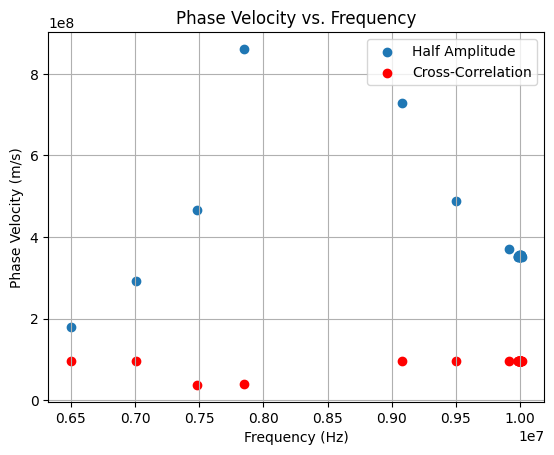

In [ ]:
mso.write(':RUN')

#Measuring phase velocity from sweep of pulse wave frequency
x2, y2, y22 = extract_sweep_delay_data2(mso, ks, pulse_wave2, 1, 3, 10)
plot_freq_vop2(x2, y2, y22)

In [ ]:
#Creating an arbitrary waveform
time_step = 0.001
time = np.arange(0, 1, time_step)

amplitude1 = 0.2
frequency1 = 10

amplitude2 = 0.8
frequency2 = 14

amplitude3 = 0.6
frequency3 = 18

waveform1 = amplitude1*np.sin(2*np.pi*frequency1*time)
waveform2 = amplitude2*np.sin(2*np.pi*frequency2*time)
waveform3 = amplitude3*np.sin(2*np.pi*frequency3*time)

arbitrary_waveform = waveform1 + waveform2 + waveform3

#Add noise
arbitrary_waveform = arbitrary_waveform + 0.3*np.random.rand(len(arbitrary_waveform))

#Normalize the waveform
arbitrary_waveform = arbitrary_waveform / np.max(np.abs(arbitrary_waveform))

In [ ]:
def export_to_arb(instrument, waveform, file_name):
    """
    Export an arbitrary waveform to a .arb file.
    """
    with open(file_name + '.arb', 'w') as file:
        file.write("#ARB\n")
        file.write(f"#NAME {file_name}\n")
        file.write(f"#POINTS {len(waveform)}\n")
        for point in waveform:
            file.write(f"{point:.5f}\n")

In [ ]:
export_to_arb(ks, arbitrary_waveform, 'test_arb')

In [ ]:
def save_arb_waveform(instrument, file_name):
    """
    Save an arbitrary waveform to the instrument's memory.
    """
    instrument.write(f'MMEM:STORE:DATA "INT:\{file_name}.arb"')


<string>:5: SyntaxWarning: invalid escape sequence '\{'
<>:5: SyntaxWarning: invalid escape sequence '\{'
<string>:5: SyntaxWarning: invalid escape sequence '\{'
<>:5: SyntaxWarning: invalid escape sequence '\{'
C:\Users\SQEIP-Tech\AppData\Local\Temp\ipykernel_3096\1032804893.py:5: SyntaxWarning: invalid escape sequence '\{'
  instrument.write(f'MMEM:STORE:DATA "INT:\{file_name}.arb"')


In [ ]:
save_arb_waveform(ks, 'test_arb')

In [ ]:
class arb_wave(waveform):
    """
    Class for an arbitrary wave (child class of waveform).

    This class sets the waveform type to arbitrary and applies the specified arb file waveform
    to the specified channel of the instrument.

    function_type is set to 'ARB' by default.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.shape = 'ARB'

    def apply(self, instrument, file_name):
        instrument.write(f'MMEM:LOAD:DATA "INT:\{file_name}.arb"')
        instrument.write(f'FUNC:ARB "INT:\{file_name}.arb"')

        #Ensure waveform generator hasn't outputted an error
        error_message = instrument.ask("SYSTem:ERRor?")
        print(error_message)

        print(f"Arbitrary waveform from {file_name} is now being outputted.")    

<string>:15: SyntaxWarning: invalid escape sequence '\{'
<string>:16: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:16: SyntaxWarning: invalid escape sequence '\{'
<string>:15: SyntaxWarning: invalid escape sequence '\{'
<string>:16: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:16: SyntaxWarning: invalid escape sequence '\{'
C:\Users\SQEIP-Tech\AppData\Local\Temp\ipykernel_3096\19119051.py:15: SyntaxWarning: invalid escape sequence '\{'
  instrument.write(f'MMEM:LOAD:DATA "INT:\{file_name}.arb"')
C:\Users\SQEIP-Tech\AppData\Local\Temp\ipykernel_3096\19119051.py:16: SyntaxWarning: invalid escape sequence '\{'
  instrument.write(f'FUNC:ARB "INT:\{file_name}.arb"')


In [ ]:
arb_wave1 = arb_wave()
arb_wave1.apply(ks, 'test_arb') 

-102,"Syntax error"
Arbitrary waveform from test_arb is now being outputted.


In [ ]:
mso.screenshot('./40ns_pulse_width.png')

Screen image written to ./40ns_pulse_width.png


array([[[235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        ...,
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255]],

       [[235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        ...,
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255]],

       [[235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        ...,
        [235, 233, 230, 255],
        [235, 233, 230, 255],
        [235, 233, 230, 255]],

       ...,

       [[235, 233, 230, 255],
        [167, 157, 143, 255],
        [167, 157, 143, 255],
        ...,
        [235, 233, 230, 255],
        [245, 244, 243, 255],
        [235, 233, 230, 255]],

       [[235, 233, 230, 255],
        [245, 244, 243, 255],
        [245, 244, 243, 255],
        ...,
        [245, 244, 243, 255],
        [245, 244, 243, 255],
        [235, 233, 230, 255]],

       [[235

In [ ]:
def half_max_time_delay(x, y1, y2):
    """
    Calculate the time delay at half the maximum amplitude of the waveform.
    """
    # Ensure y1 and y2 are numpy arrays
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    # Find the maximum amplitude
    max_amplitude = np.max(np.abs(y1))

    # Find the half maximum value
    half_max = max_amplitude / 2

    # Find indices where y1  and y2 cross half_max
    indices1 = np.where(np.diff(np.sign(y1 - half_max)))[0]

    indices2 = np.where(np.diff(np.sign(y2 - half_max)))[0]

    if len(indices1) < 2:
        raise ValueError("Not enough points to determine time delay at half maximum.")

    # Calculate time delay between the two waves
    time_delay = x[indices1[0]] - x[indices2[0]]

    return float(time_delay)

In [ ]:
import pandas as pd

def export_sweep_data(instrument, fg, wave, channel, channel2, sweep_time, file_name):
    """
    Extract time delay data from the specified channel of the instrument during a frequency sweep.
    """

    freq_to_traces = {}

    wave.apply(ks)

    wave.output_on(ks)  # Toggle output on function generator channel 1
    
    start_time = time.time()

    instrument.write(':TIMEBASE:SCALE 50.0E-9')

    getattr(instrument, f'ch{channel}').display(True)
    getattr(instrument, f'ch{channel2}').display(True)

    wave.sweep_frequency(fg, start_freq=2e6, stop_freq=7e6, return_time = 0, hold_time = 5, sweep_time=sweep_time, sweep_spacing='LIN')

    time.sleep(3)  # Allow time for the sweep to start

    while True:
        now = time.time()
        elapsed = now - start_time
        if elapsed > sweep_time:
            break

        # Measure frequency
        freq = measure_frequency(instrument, channel)

        # Disable automatic digitization
        instrument.auto_digitize(False)

        #Measure time delay using correlation
        # Set up trigger, sample rate, etc.
        nPoints = 5000
        instrument.acquire_points(nPoints)
        instrument.sample_rate(nPoints / mso.timebase_range())
        instrument.acquire_interpolate(0)
        
        instrument.trigger_edge_source('CHAN1')
        instrument.ch1.trigger_level(0)

        #Take measurement (single digitize for both channels)
        instrument.digitize()

        # Get trace data from both channels
        y1 = getattr(instrument, f'ch{channel}').trace()
        y2 = getattr(instrument, f'ch{channel2}').trace()

        # Calculate time axis manually
        t_range = instrument.timebase_range()  # total time window in s
        t_center = instrument.timebase_position()  # center of time window
        t_start = t_center - t_range / 2
        t_stop = t_center + t_range / 2
        t = np.linspace(t_start, t_stop, nPoints)

        freq_to_traces[float(freq)] = (y1, y2, t)



    getattr(fg, f'ch{channel}').write('SOURce' +str(channel)+':SWEep:STATe OFF')
    
    import pickle
    with open(file_name + '.pkl', 'wb') as f:
        pickle.dump(freq_to_traces, f)

In [ ]:
export_sweep_data(mso, ks, pulse_wave2, 1, 3, 5, 'pulse_wave_2_sweep_data')

+0,"No error"
PULS wave applied on channel 1: 
Frequency=5000000.0 Hz, 
Amplitude=3 Vpp, 
Offset=0.0 V, 
Phase=0.0 degrees
+0,"No error"
Pulse width=8.4e-08 s, Lead edge=8.4e-09 s, Trail edge=8.4e-09 s
Output on channel 1 already turned ON.


In [ ]:
def process_sweep(file_name):
    """
    Process the sweep data from the specified file.
    """
    with open(file_name + '.pkl', 'rb') as f:
        freq_to_traces = pickle.load(f)

    freqs = []
    delays = []
    delays2 = []

    for freq, (trace1, trace2, time) in freq_to_traces.items():
        freqs.append(freq)

        # Calculate time delay using cross-correlation
        delays.append(calculate_time_delay(time, y1, y2))
        delays2.append(half_max_time_delay(time, y1, y2))

    return freqs, delays, delays2

sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
sample interval:  1.0002000400077549e-10
212822630.72100317
212822630.72100317
212822630.72100317
212822630.72100317
212822630.72100317
212822630.72100317
212822630.72100317
212822630.72100317
212822630.72100317
212822630

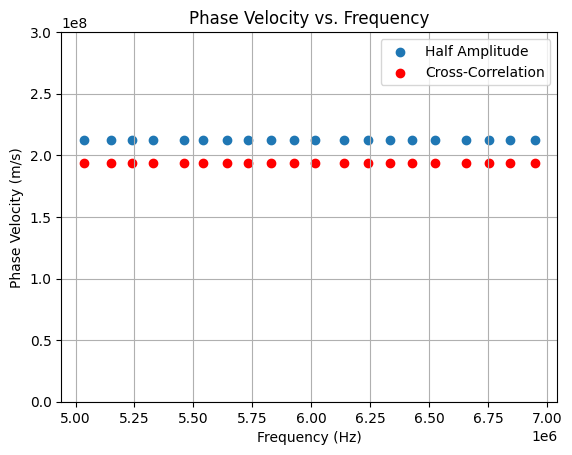

-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213
-193972626.28576213


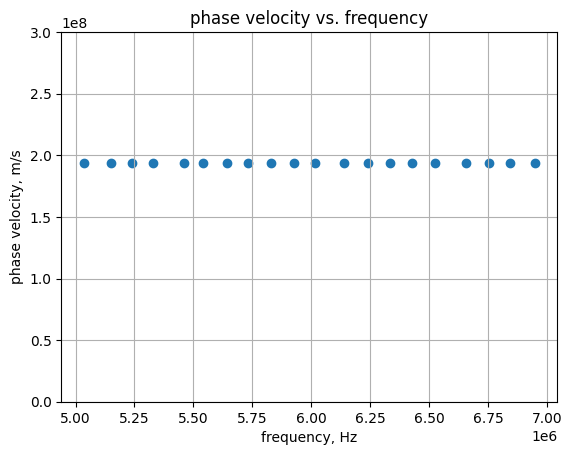

In [ ]:
frqs, delays, delays2 = process_sweep('pulse_wave_2_sweep_data')
plot_freq_vop2(frqs, delays2, delays)
plot_freq_vop(frqs, delays)

In [22]:
def export_wave_data(instrument, ks, wave, channel1, channel2, file_name):
    """
    Export waveform data from the specified channels of the instrument to a CSV file.
    """
    # Ensure the waveform is applied
    wave.apply(ks)
    wave.output_on(ks)  # Toggle output on specified channel
    time.sleep(2)  # Wait for the waveform to apply

    #autoscale(instrument)
    # Disable automatic digitization
    instrument.auto_digitize(False)

    nPoints = 1000000
    instrument.acquire_points(nPoints)
    instrument.sample_rate(nPoints / mso.timebase_range())
    instrument.acquire_interpolate(0)

    instrument.trigger_edge_source('CHAN1')
    instrument.ch1.trigger_level(0)

    # Take the measurement (single digitize for both channels)
    instrument.digitize()

    y1 = getattr(instrument, f'ch{channel1}').trace()
    y2 = getattr(instrument, f'ch{channel2}').trace()

    # Calculate time axis manually
    t_range = instrument.timebase_range()  # total time window in s
    t_center = instrument.timebase_position()  # center of time window
    t_start = t_center - t_range / 2
    t_stop = t_center + t_range / 2
    x = np.linspace(t_start, t_stop, len(y1))

    # Create DataFrame and save to CSV
    df = pd.DataFrame({'Time (s)': x, f'Channel {channel1}': y1, f'Channel {channel2}': y2})
    df.to_csv(file_name + '.csv', index=False)

    instrument.write(':RUN')

In [ ]:
export_wave_data(mso, ks, pulse_wave2, 1, 3, 'pulse_wave_2_wave_data')

+0,"No error"
PULS wave applied on channel 1: 
Frequency=5000000.0 Hz, 
Amplitude=3 Vpp, 
Offset=0.0 V, 
Phase=0.0 degrees
+0,"No error"
Pulse width=8.4e-08 s, Lead edge=8.4e-09 s, Trail edge=8.4e-09 s
Output on channel 1 already turned ON.


sample interval:  2.0004000800155098e-10
-6.921384276853664e-08
-7.041408281656336e-08


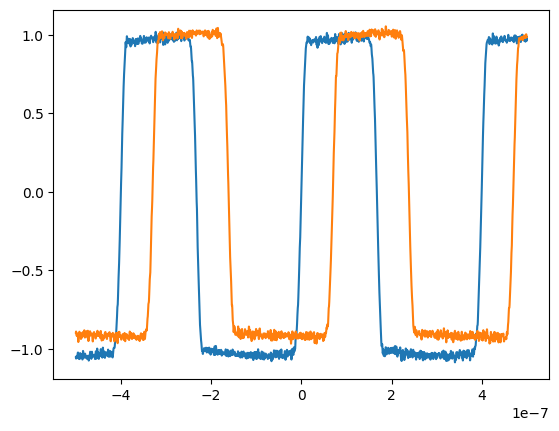

In [ ]:
pw2_t = pd.read_csv('pulse_wave_2_wave_data.csv')['Time (s)'].values
pw2_ch1 = pd.read_csv('pulse_wave_2_wave_data.csv')['Channel 1'].values
pw2_ch3 = pd.read_csv('pulse_wave_2_wave_data.csv')['Channel 3'].values
plt.figure()
plt.plot(pw2_t, pw2_ch1, label='Channel 1')
plt.plot(pw2_t, pw2_ch3, label='Channel 3')

print(calculate_time_delay(pw2_t, pw2_ch1, pw2_ch3))
print(half_max_time_delay(pw2_t, pw2_ch1, pw2_ch3))

In [ ]:
export_wave_data(mso, ks, sin1, 1, 3, 'sin1_wave_data')

+0,"No error"
SIN wave applied on channel 1: 
Frequency=10000000.0 Hz, 
Amplitude=2.0 Vpp, 
Offset=0.0 V, 
Phase=0 degrees
Output on channel 1 already turned ON.


sample interval:  1.0002000400077549e-10
-3.500700140027142e-08
3.21064212842569e-08


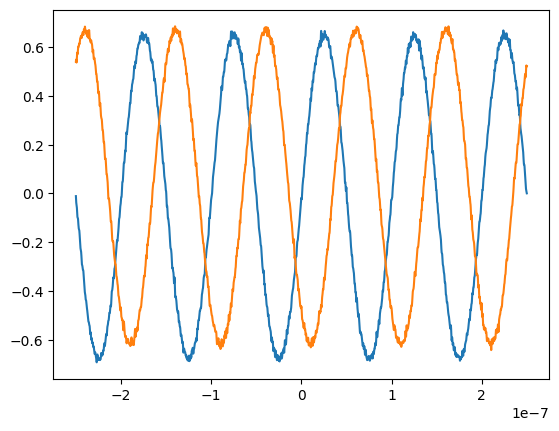

In [ ]:
pw2_t = pd.read_csv('sin1_wave_data.csv')['Time (s)'].values
pw2_ch1 = pd.read_csv('sin1_wave_data.csv')['Channel 1'].values
pw2_ch3 = pd.read_csv('sin1_wave_data.csv')['Channel 3'].values
plt.figure()
plt.plot(pw2_t, pw2_ch1, label='Channel 1')
plt.plot(pw2_t, pw2_ch3, label='Channel 3')

print(calculate_time_delay(pw2_t, pw2_ch1, pw2_ch3))
print(half_max_time_delay(pw2_t, pw2_ch1, pw2_ch3))

In [ ]:
pulse_wave2 = pulse_wave(pulse_width=84e-9, lead_edge = 8.4e-9, trail_edge = 8.4e-9, frequency=5e6, amplitude=3, channel=1)
pulse_wave2.apply(ks)

+0,"No error"
PULS wave applied on channel 1: 
Frequency=5000000.0 Hz, 
Amplitude=3 Vpp, 
Offset=0.0 V, 
Phase=0.0 degrees
+0,"No error"
Pulse width=8.4e-08 s, Lead edge=8.4e-09 s, Trail edge=8.4e-09 s


In [ ]:
sin1 = sine_wave(frequency=10e6, amplitude=2.0, offset=0.0, phase=0, channel=1)
sin1.apply(ks)

+0,"No error"
SIN wave applied on channel 1: 
Frequency=10000000.0 Hz, 
Amplitude=2.0 Vpp, 
Offset=0.0 V, 
Phase=0 degrees


In [ ]:
export_wave_data(mso, ks, pulse_wave2, 1, 3, 'pulse_wave_2_wave_data2')

+0,"No error"
PULS wave applied on channel 1: 
Frequency=5000000.0 Hz, 
Amplitude=3 Vpp, 
Offset=0.0 V, 
Phase=0.0 degrees
+0,"No error"
Pulse width=8.4e-08 s, Lead edge=8.4e-09 s, Trail edge=8.4e-09 s
Output on channel 1 already turned ON.


In [ ]:
#100 ns to 50ns horizontal
pw22_t = pd.read_csv('pulse_wave_2_wave_data2.csv')['Time (s)'].values
pw22_ch1 = pd.read_csv('pulse_wave_2_wave_data2.csv')['Channel 1'].values
pw22_ch3 = pd.read_csv('pulse_wave_2_wave_data2.csv')['Channel 3'].values

print(calculate_time_delay(pw22_t, pw22_ch1, pw22_ch3))
print(half_max_time_delay(pw22_t, pw22_ch1, pw22_ch3))

sample interval:  1.0002000400077549e-10
-3.4706941388269095e-08
-3.51070214042808e-08


In [28]:
def extract_traces(waveform, file_name):
    waveform.apply(ks)
    instrument.write(':RUN')

    for i in range(1, 11):
        time.sleep(1)
        export_wave_data(mso, ks, waveform, 1, 3, file_name + str(i))


In [15]:
my_wave = triangle_wave(frequency=500,amplitude=500e-3,offset=250e-3,phase=0,channel=1)
extract_traces(3, my_wave,'test_traces')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Ph

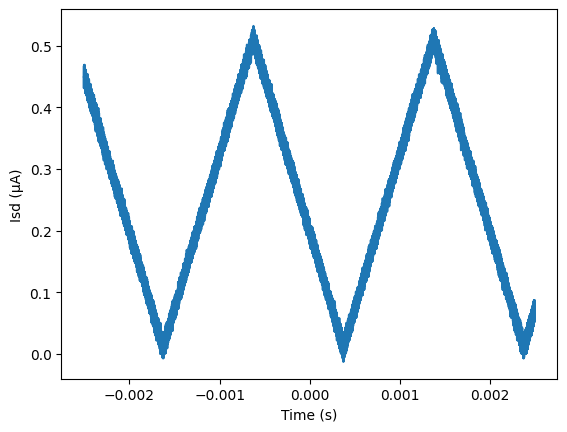

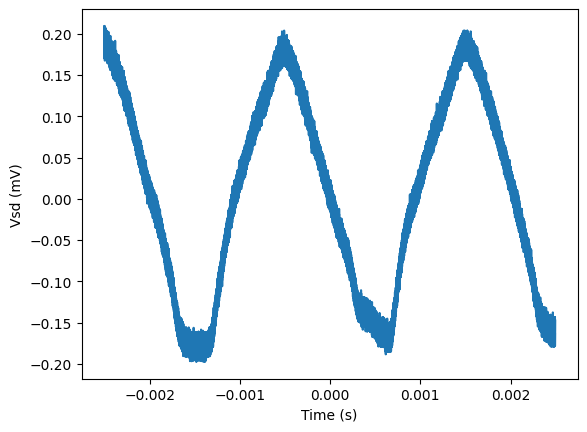

In [18]:
test_traces_time = pd.read_csv('test_traces0.csv')['Time (s)'].values
test_traces_Isd = pd.read_csv('test_traces0.csv')['Channel 1'].values
test_traces_Vsd = pd.read_csv('test_traces0.csv')['Channel 3'].values

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Isd (µA)')
plt.plot(test_traces_time, test_traces_Isd, label='Channel 1')

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Vsd (mV)')
plt.plot(test_traces_time, test_traces_Vsd, label='Channel 3')

In [30]:
extract_traces(my_wave,'JJ31_Vg=-3.0V_96mK_traces')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0

In [31]:
extract_traces(my_wave,'JJ21_Vg=-4.5V_96mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0

In [32]:
extract_traces(my_wave,'JJ11_Vg=-4.5V_96mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0

In [36]:
my_wave2 = triangle_wave(frequency=500,amplitude=800e-3,offset=250e-3,phase=0,channel=1)
extract_traces(my_wave2,'JJ12_Vg=-4.5V_96mK_traces')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [38]:
extract_traces(my_wave2,'JJ13_Vg=-4.0V_96mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [39]:
extract_traces(my_wave2,'JJ23_Vg=-4.0V_96mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [41]:
extract_traces(my_wave2,'JJ33_Vg=-2.0V_96mK_traces')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.


KeyboardInterrupt: 

In [45]:
extract_traces(my_wave2,'JJ33_Vg=-2.0V_150mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [46]:
extract_traces(my_wave2,'JJ23_Vg=-4.0V_150mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [48]:
extract_traces(my_wave2,'JJ13_Vg=-4.0V_150mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [49]:
extract_traces(my_wave2,'JJ12_Vg=-4.5V_150mK_traces')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.8 Vpp, 
Offset=0

In [50]:
extract_traces(my_wave,'JJ11_Vg=-4.5V_150mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0

In [52]:
extract_traces(my_wave,'JJ21_Vg=-4.5V_150mK_trace')

+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
-113,"Undefined header"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0.25 V, 
Phase=0 degrees
Output on channel 1 already turned ON.
+0,"No error"
TRI wave applied on channel 1: 
Frequency=500 Hz, 
Amplitude=0.5 Vpp, 
Offset=0